## Data processing
This script fetches and processes data from a user's anime list on MyAnimeList

In [87]:
import requests
import pandas as pd
from config import CLIENT_ID, USER_NAME

# Constructing the URL for API request using USER_NAME
url = f'https://api.myanimelist.net/v2/users/{USER_NAME}/animelist'

# Setting headers for the API request, including the CLIENT_ID
headers = {
    'X-MAL-CLIENT-ID': CLIENT_ID
}

# Setting parameters for the API request to specify limit and fields
params = {
    'limit': 400,
    'fields': 'list_status{score},alternative_titles{en},mean,genres,popularity'
}

# Making a GET request to the API endpoint
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    # Parsing the JSON response into Python dictionary
    anime_data = response.json()
    
    modified_anime_data = []
    
    # Iterating through each anime entry in the API response
    for anime in anime_data['data']:
        anime_info = anime['node']  # Extracting anime information
        list_status = anime.get('list_status', {})  # Extracting list status information
        
        # Creating a modified anime entry with selected attributes
        modified_anime = {
            'user_score': list_status.get('score'),
            'title': anime_info.get('alternative_titles', {}).get('en'),
            'mal_score': anime_info.get('mean'),
            'genres': [genre['name'] for genre in anime_info.get('genres', [])],
            'popularity': anime_info.get('popularity')
        }
        
        modified_anime_data.append(modified_anime)
    
    # Creating a DataFrame from the modified anime data
    df = pd.DataFrame(modified_anime_data)
    print(df.head(2))
    

    csv_file_path = './data/anime_list.csv'
    df.to_csv(csv_file_path, index=False, encoding='utf-8')

    print(f"Data successfully written to '{csv_file_path}'")
else:
    print(f"Failed to retrieve data: {response.status_code}")

   user_score                            title  mal_score  \
0           4  I'm Standing on a Million Lives       6.51   
1           6                             22/7       6.79   

                                      genres  popularity  
0  [Action, Drama, Fantasy, Isekai, Shounen]         833  
1             [Drama, Idols (Female), Music]        3230  
Data successfully written to './data/anime_list.csv'


## Neural Network training
This script performs data preprocessing and trains a neural network to predict user scores for anime titles

In [89]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras import regularizers
import numpy as np


df = pd.read_csv('./data/anime_list.csv')
# Loading the pre-trained Word2Vec model
word_vectors = Word2Vec.load('./models/anime_word2vec_model_updated')

df.columns = df.columns.astype(str)
# Handling missing values in the title column by replacing them with empty strings
df['title'] = df['title'].fillna('')

# Function to convert anime titles into vectors using the Word2Vec model
def title_to_vector(anime_title):
    # Getting the vector size from the model
    vector_size = word_vectors.vector_size
    # Initializing the vector with zeros
    vector = np.zeros(vector_size)
    # Split the title into individual words
    words = str(anime_title).split()
    word_count = 0
    for word in words:
        # Checking if the word exists in the Word2Vec vocabulary
        if word in word_vectors.wv:
            vector += word_vectors.wv[word]
            word_count += 1
    # Returning the average vector or a zero vector if no words found
    return vector / word_count if word_count > 0 else vector

df['title_vector'] = df['title'].apply(title_to_vector)

# Converting the title_vector column into separate columns for each vector component
title_vectors = pd.DataFrame(df['title_vector'].tolist(), index=df.index)
df = pd.concat([df, title_vectors], axis=1).drop(['title_vector', 'title'], axis=1)

# One-hot encoding the genres column
genres_encoder = OneHotEncoder(sparse_output=False)
genres_encoded = genres_encoder.fit_transform(df[['genres']])
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genres_encoder.get_feature_names_out(['genres']))
df = pd.concat([df, genres_encoded_df], axis=1).drop('genres', axis=1)

# Ensuring all column names are strings
df.columns = df.columns.astype(str)

# Normalizing numerical data using StandardScaler
numerical_columns = ['mal_score',  'popularity', 'user_score']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Defining the target variable Y and features X
Y = df['user_score']
X = df.drop(['user_score'], axis=1)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Defining the neural network model architecture
# Number of input features
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compiling the model with optimizer, loss function, and evaluation metrics
model.compile(optimizer='sgd',
              loss='mse',  # Mean Squared Error
              metrics=['mae'])  # Mean Absolute Error

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the model on the test data
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {mae}')

Epoch 1/100


C:\Users\dobre\Documents\Code\Anime_Rating_Project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0980 - mae: 0.8076 - val_loss: 1.2166 - val_mae: 0.8749
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1553 - mae: 0.8459 - val_loss: 1.1774 - val_mae: 0.8600
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1585 - mae: 0.8596 - val_loss: 1.1460 - val_mae: 0.8469
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1352 - mae: 0.8435 - val_loss: 1.1151 - val_mae: 0.8306
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0292 - mae: 0.7870 - val_loss: 1.0880 - val_mae: 0.8178
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0742 - mae: 0.8146 - val_loss: 1.0661 - val_mae: 0.8084
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0000 - mae: 0.7837 - val_loss: 1.0446 - val_mae: 0.7978
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9732 - mae: 0.7762 - val_loss: 1.0279 - val_mae: 0.7886
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9909 - mae: 0.7739 - val_loss: 1

## Visualizing
This script uses matplotlib to visualize the training history of a neural network model, focusing on loss and Mean Absolute Error (MAE) metrics

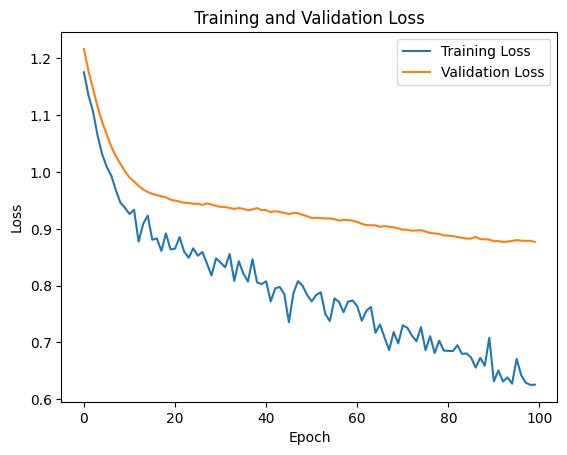

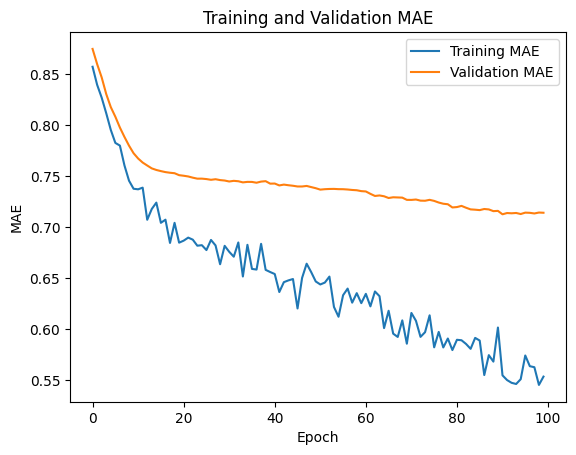

In [90]:
import matplotlib.pyplot as plt

# Getting the loss and metric values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation MAE over epochs
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()